# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Изучение общей информации. 

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
pd.set_option('display.max_columns', None)
data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,False,False,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,False,False,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,False,False,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,False,False,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,False,False,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,False,False,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,False,False,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,False,False,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,False,False,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


Количество строк:

In [3]:
start = len(data) 
print(start )

23699


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Общая гистограмма

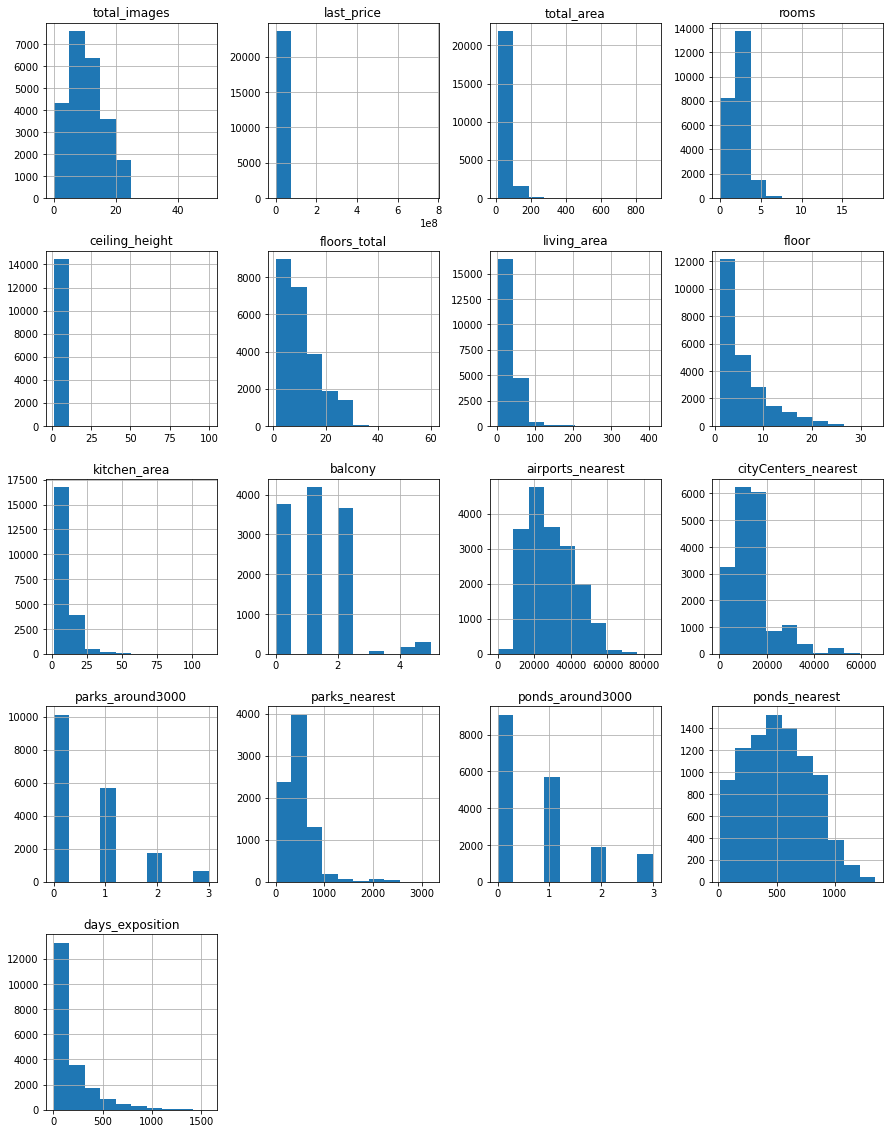

In [5]:
data.hist(figsize=(15, 20));

Если рассматривать исходные данные без предобработки, то можно сделать следующие выводы:
    
    - итоговая цена не превышает 1е8 рублей
    - площадь не превышает 300 м^2
    - большенство квартир 2-3 комнатные
По общей информации видно, что существует множество пустых ячеек

### Предобработка данных

Столбцы, в которых есть пропуски

In [6]:
#проверка в каких столбцах есть пропуски:
for column in data:
    val_col = data[column]
    if val_col.isna().sum() > 0:
        print(column)    

ceiling_height
floors_total
living_area
is_apartment
kitchen_area
balcony
locality_name
airports_nearest
cityCenters_nearest
parks_around3000
parks_nearest
ponds_around3000
ponds_nearest
days_exposition


Среди этих столбцов есть те, где легко заполнить пропускию
В столбцах is_apartment, balcony, parks_around3000, ponds_around3000 пропуски скорее всего обозначают отсутствие наличия интересуемых моментов или отрицательный ответ. Заполним их:

In [7]:
data['is_apartment'] = data['is_apartment'].fillna(False)
data['balcony'] = data['balcony'].fillna(0)
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)

Теперь разберемся с остальными столбцами. В ceiling_height, floors_total, living_area, kitchen_area можно заменить значения медианным, чтобы проводить дальнейшее исследование, так как в этих стобцах могут быть серьезные отклонения, которые исказят средний результат и он будет неправдоподобный. Однако не забываем про зависимость столбцов living_area и kitchen_area от столбца total_area. Для максимально четкого анализа предлагаю следующую схему:
1. найти медианное значение доли площади кухни от общей площади квартиры (med_k)
2. заполнять пропуски значением med_k'*'Sквартиры

Аналогично поступаем с living_area

In [8]:
median_col = ['ceiling_height', 'floors_total']

for val in median_col:
    data[val] = data[val].fillna(round(data[val].median()))


median_kitchen = data['kitchen_area'].median()
median_living = data['living_area'].median()
median_total = data['total_area'].median()
med_k = median_kitchen/median_total
med_l = median_living/median_total

print('медианное значение площади кухни', median_kitchen)
print('медианное значение жилой площади', median_living)
print('медианное значение доли площади кухни от общей площади квартиры', med_k)
print('медианное значение доли жилой площади от общей площади квартиры', med_l)


#Разбираемся с кухней
data['kitchen_area'] = data['kitchen_area'].fillna(round(data['total_area']*med_k))
#Разбираемся с жилой площадью  
data['living_area'] = data['living_area'].fillna(round(data['total_area']*med_l))     

медианное значение площади кухни 9.1
медианное значение жилой площади 30.0
медианное значение доли площади кухни от общей площади квартиры 0.175
медианное значение доли жилой площади от общей площади квартиры 0.5769230769230769


Пропуски в столбцах с картографическими данными не будем трогать, так как нельзя получить достоверную информацию.
В столбце days_exposition пропуски означают, что квартира не продана. Соответственно, их заполнение невозможно. 
Но эти пропуски не должны оказать большое влияние на общий анализ данных

А вот строки, где имеются пропуски в столбце locality_name думаю, нужно удалить. Так как замена пропусков на случайное значение может привести к нереалистичным результатам и процент подобных строк совсем невелик.

In [9]:
#Процент 
print(data['locality_name'].isna().sum()/len(data)*100, '%')

0.20675977889362418 %


In [10]:
#Удаляем строки с пропусками в этом столбце
data = data[data['locality_name'].isna() == False].reset_index()

Теперь изменим некоторым столбцам тип данных, чтобы все было корректно и логично

Можем заметить, что столбцы last_price, floors_total, balcony, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_neares, days_exposition на самом деле содержат целые значения.

In [11]:
pruv = ['last_price', 'floors_total', 'balcony', 'airports_nearest', 'cityCenters_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest', 'days_exposition']
for val in pruv:
    k = data['cityCenters_nearest'].multiply(10).mod(10).sum()
    print('cумма десятичных частей в', val, k)

cумма десятичных частей в last_price 0.0
cумма десятичных частей в floors_total 0.0
cумма десятичных частей в balcony 0.0
cумма десятичных частей в airports_nearest 0.0
cумма десятичных частей в cityCenters_nearest 0.0
cумма десятичных частей в parks_around3000 0.0
cумма десятичных частей в parks_nearest 0.0
cумма десятичных частей в ponds_around3000 0.0
cумма десятичных частей в ponds_nearest 0.0
cумма десятичных частей в days_exposition 0.0


In [12]:
#Изменяем типы данных
data['last_price'] = data['last_price'].astype('int')
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%dT%H:%M:%S')
data['floors_total'] = data['floors_total'].astype('int')
data['is_apartment'] = data['is_apartment'].astype('bool')
data['balcony'] = data['balcony'].astype('int')
data['airports_nearest'] = data['airports_nearest'].astype('int', errors='ignore')
data['cityCenters_nearest'] = data['cityCenters_nearest'].astype('int', errors='ignore')
data['parks_around3000'] = data['parks_around3000'].astype('int')
data['parks_nearest'] = data['parks_nearest'].astype('int', errors='ignore')
data['ponds_around3000'] = data['ponds_around3000'].astype('int')
data['ponds_nearest'] = data['ponds_nearest'].astype('int', errors='ignore')
data['days_exposition'] = data['days_exposition'].astype('int', errors='ignore')
print('Убедимся, что все изменения выполнены')

data.info()

Убедимся, что все изменения выполнены
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23650 entries, 0 to 23649
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   index                 23650 non-null  int64         
 1   total_images          23650 non-null  int64         
 2   last_price            23650 non-null  int64         
 3   total_area            23650 non-null  float64       
 4   first_day_exposition  23650 non-null  datetime64[ns]
 5   rooms                 23650 non-null  int64         
 6   ceiling_height        23650 non-null  float64       
 7   floors_total          23650 non-null  int64         
 8   living_area           23650 non-null  float64       
 9   floor                 23650 non-null  int64         
 10  is_apartment          23650 non-null  bool          
 11  studio                23650 non-null  bool          
 12  open_plan             23650 non-null

Проверим DataFrame на наличие явных дубликатов

In [13]:
print(data.duplicated().sum())

0


Явные дубликаты отсутствуют. Теперь нужно рассмотреть, есть ли неявные дубликаты в названиях населённых пунктов

In [14]:
print(data['locality_name'].unique())

['Санкт-Петербург' 'посёлок Шушары' 'городской посёлок Янино-1'
 'посёлок Парголово' 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф'
 'Пушкин' 'деревня Кудрово' 'Коммунар' 'Колпино'
 'поселок городского типа Красный Бор' 'Гатчина' 'поселок Мурино'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой'
 'посёлок городского типа Лебяжье' 'посёлок городского типа Сиверский'
 'поселок Молодцово' 'поселок городского типа Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'поселок городского типа Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'поселок Торковичи'
 'поселок Первомайское' 'Красное Село' 'посёлок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'посёлок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское'
 'Зеленогорск' 'Сосновый Бор' 'поселок Новый Све

Самыми распространенными случаями неявных дубликатов является разный регистр и путаница с буквами е и ё. Также было предположение, что нужно удалить пояснения (то есть деревня, поселок и т.д), но я подумала, что одни и те же названия могут быть у разных населенных пунктов, поэтому так делать не стоит. Рационально заменить только синонимы городской посёлок на поселок городского типа

In [15]:
#приведем все к нижнему регистру
data['locality_name'] = data['locality_name'].str.lower() 

#заменим на е и убирем синонимы
def local(text):
    if 'посёлок' in text: 
        text = text.replace('посёлок', 'поселок')  
    return text

data['locality_name'] = data['locality_name'].apply(local)
data['locality_name'] = data['locality_name'].replace('городской посёлок','поселок городского типа')


print(data['locality_name'].unique())

['санкт-петербург' 'поселок шушары' 'городской поселок янино-1'
 'поселок парголово' 'поселок мурино' 'ломоносов' 'сертолово' 'петергоф'
 'пушкин' 'деревня кудрово' 'коммунар' 'колпино'
 'поселок городского типа красный бор' 'гатчина' 'деревня фёдоровское'
 'выборг' 'кронштадт' 'кировск' 'деревня новое девяткино'
 'поселок металлострой' 'поселок городского типа лебяжье'
 'поселок городского типа сиверский' 'поселок молодцово'
 'поселок городского типа кузьмоловский'
 'садовое товарищество новая ропша' 'павловск' 'деревня пикколово'
 'всеволожск' 'волхов' 'кингисепп' 'приозерск' 'сестрорецк'
 'деревня куттузи' 'поселок аннино' 'поселок городского типа ефимовский'
 'поселок плодовое' 'деревня заклинье' 'поселок торковичи'
 'поселок первомайское' 'красное село' 'поселок понтонный' 'сясьстрой'
 'деревня старая' 'деревня лесколово' 'поселок новый свет' 'сланцы'
 'село путилово' 'ивангород' 'мурино' 'шлиссельбург' 'никольское'
 'зеленогорск' 'сосновый бор' 'деревня оржицы' 'деревня кальтино'

Теперь нужно рассмотреть выбросы

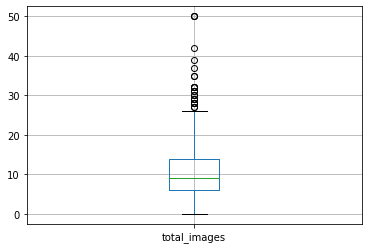

значения, до которого доходит 99,5% значений 20.0


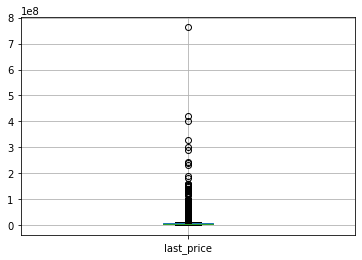

значения, до которого доходит 99,5% значений 54755000.00000102


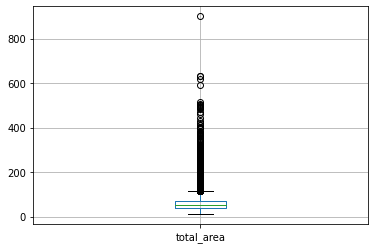

значения, до которого доходит 99,5% значений 248.92650000000032


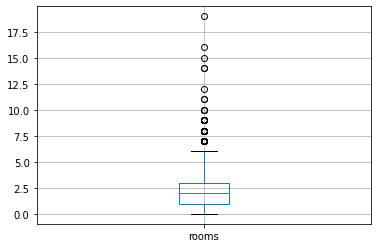

значения, до которого доходит 99,5% значений 6.0


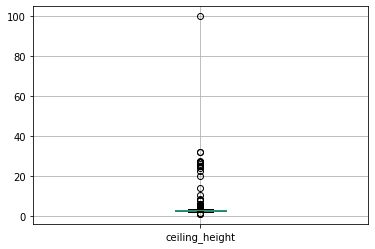

значения, до которого доходит 99,5% значений 3.95


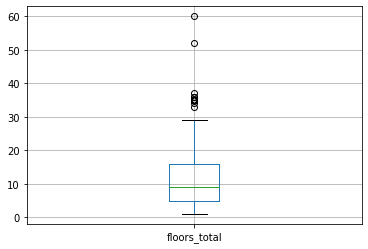

значения, до которого доходит 99,5% значений 27.0


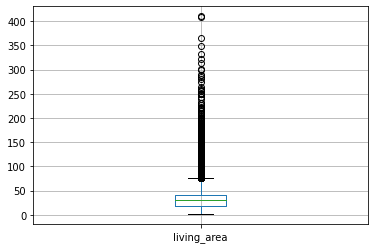

значения, до которого доходит 99,5% значений 158.66100000000222


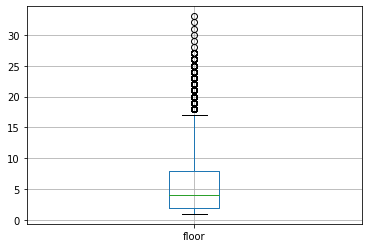

значения, до которого доходит 99,5% значений 24.0


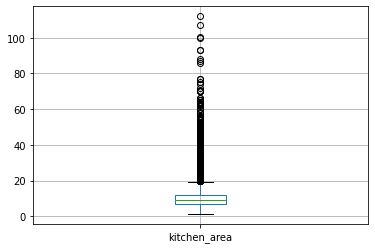

значения, до которого доходит 99,5% значений 42.95100000000021


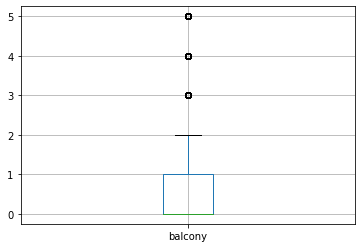

значения, до которого доходит 99,5% значений 5.0


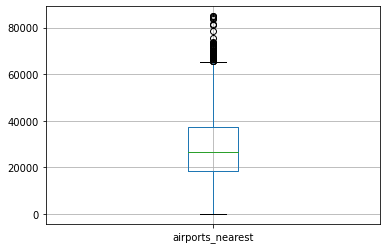

значения, до которого доходит 99,5% значений 66826.29999999986


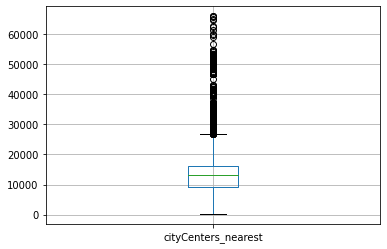

значения, до которого доходит 99,5% значений 51712.060000000034


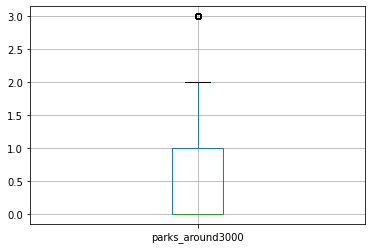

значения, до которого доходит 99,5% значений 3.0


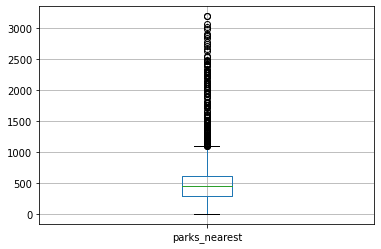

значения, до которого доходит 99,5% значений 2295.0


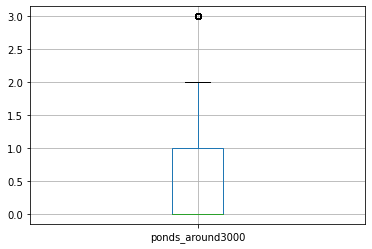

значения, до которого доходит 99,5% значений 3.0


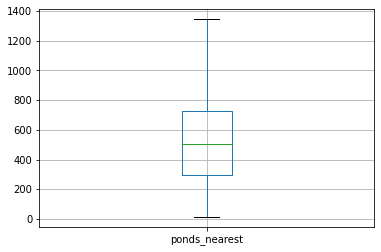

значения, до которого доходит 99,5% значений 1215.0


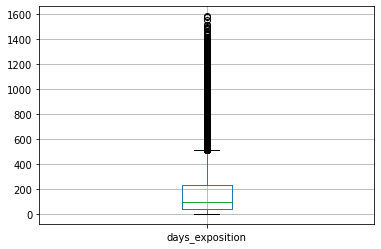

значения, до которого доходит 99,5% значений 1180.3099999999977


In [16]:
import matplotlib.pyplot as plt

col = ['total_images', 'last_price', 'total_area', 'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor', 'kitchen_area', 'balcony', 'airports_nearest', 'cityCenters_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest', 'days_exposition']

for i in col:
    data.boxplot(column = i)
    plt.show()
    quantil = data[i].quantile(0.995)
    print('значения, до которого доходит 99,5% значений', quantil)

#data = data[data[i]<=quantil].reset_index(drop=True) #избавляемся от выбрасов
    

Для того чтобы не рассматривать вырожденные случаи, сделаем так:

In [17]:
col_area = ['total_area', 'living_area', 'kitchen_area']

for i in col_area:
    quantil = data[i].quantile(0.99)
    data = data[data[i]<=quantil].reset_index(drop=True) #избавляемся от выбрасов


In [18]:
#из гистограмм
data = data[(data['total_images']<=30)].reset_index(drop=True)
data = data[data['last_price']<=7e7].reset_index(drop=True)
data = data[data['rooms']<=6].reset_index(drop=True)
data = data[data['ceiling_height']<=6].reset_index(drop=True)
data = data[data['floors_total']<= 30].reset_index(drop=True)

В столбцах 'airports_nearest', 'cityCenters_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest' очень много значений, выходящих за пределы межквартильного размаха, однако они не являются аномальными, потому что эти столбцы показывают расстояние до чего либо, и они вполне могут быть правдоподобными. Можно только отфильтровать наиболее редко встречающиеся значения, чтобы исследование показывало более общий результат.
В столбцах 'floor', 'balcony', 'parks_around3000', 'ponds_around3000', 'days_exposition' также присутствуют значения, выходящие из межквартильного размаха, однако они так же не являются аномальными.

In [19]:
col_near = ['airports_nearest', 'cityCenters_nearest', 'parks_nearest', 'ponds_nearest']

for i in col_near:
    quantil_near_max = data[i].quantile(0.995)
    quantil_near_min = data[i].quantile(0.005)
    data = data[data[i]<=quantil_near_max].reset_index(drop=True) 
    data = data[data[i]>=quantil_near_min].reset_index(drop=True) 
    #избавляемся от выбрасов

In [20]:
#минимальная жилая площадь в реали должна быть не меньше 7 кв.м (это минимальный митраж, который я нашла в интернете)
data = data[data['living_area']>= 7].reset_index(drop=True)
#минимальная высота в реали должна быть не меньше 2 м (прописано в законе)
data = data[data['ceiling_height']>= 2.5].reset_index(drop=True)
#минимальная площадь кухни в реали должна быть не меньше 3 кв.м
data = data[data['kitchen_area']>= 4].reset_index(drop=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4187 entries, 0 to 4186
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   index                 4187 non-null   int64         
 1   total_images          4187 non-null   int64         
 2   last_price            4187 non-null   int64         
 3   total_area            4187 non-null   float64       
 4   first_day_exposition  4187 non-null   datetime64[ns]
 5   rooms                 4187 non-null   int64         
 6   ceiling_height        4187 non-null   float64       
 7   floors_total          4187 non-null   int64         
 8   living_area           4187 non-null   float64       
 9   floor                 4187 non-null   int64         
 10  is_apartment          4187 non-null   bool          
 11  studio                4187 non-null   bool          
 12  open_plan             4187 non-null   bool          
 13  kitchen_area      

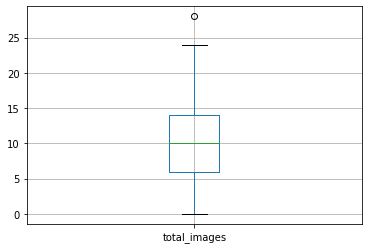

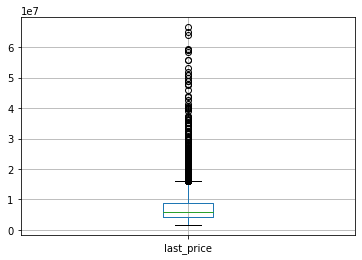

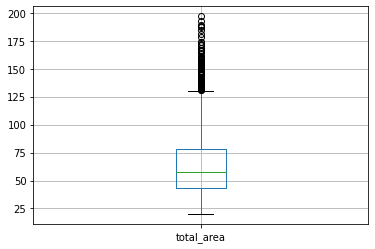

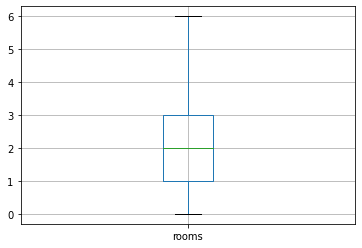

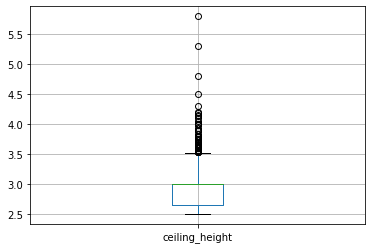

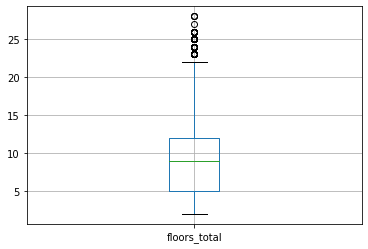

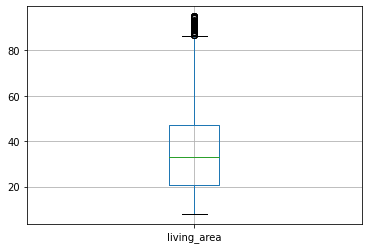

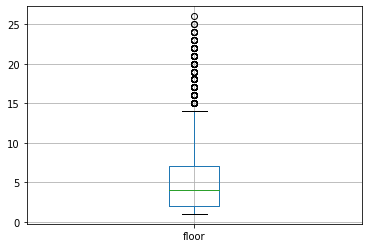

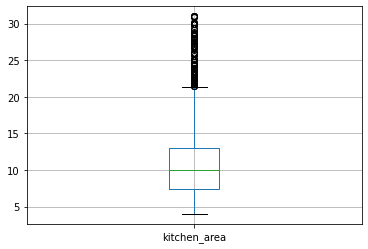

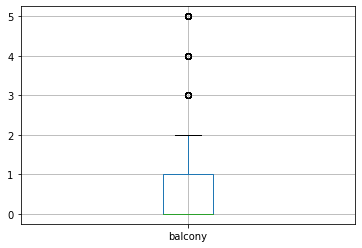

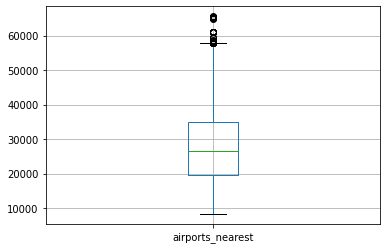

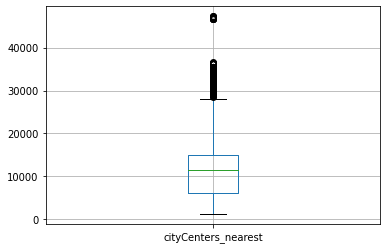

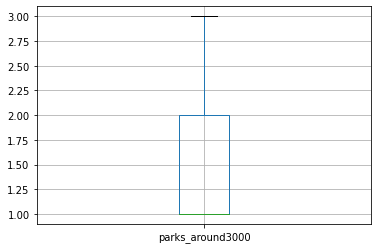

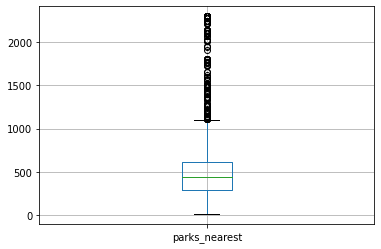

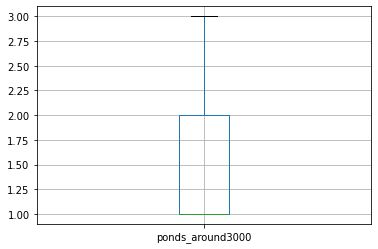

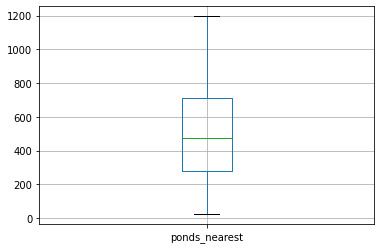

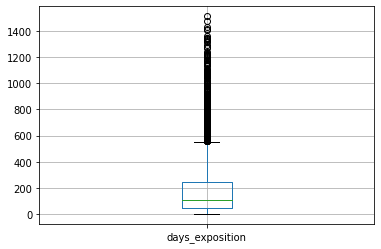

In [21]:
#проверим, что получилось
data.info()
for i in col:
    data.boxplot(column = i)
    plt.show()

Осталось убедиться, что был удален не слишком большой процент данных (меньше 10%)

In [22]:
print('удаленный процент данных', (100 - len(data)*100/start), '%' )

удаленный процент данных 82.33258787290603 %


In [23]:
data.describe()

,index,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,4187.000000,4187.000000,4.187000e+03,4187.000000,4187.000000,4187.000000,4187.000000,4187.000000,4187.000000,4187.000000,4187.000000,4187.000000,4187.000000,4187.000000,4187.000000,4187.000000,4187.000000,3597.000000
mean,11898.361595,10.087413,7.838778e+06,63.792355,2.171244,2.879859,9.567471,36.708168,5.348698,10.790191,0.517316,27499.944590,12260.505374,1.397659,502.120373,1.666109,500.181992,196.294134
std,6811.102610,5.711950,6.190925e+06,27.772365,0.998113,0.275836,5.381208,17.880303,4.120582,4.728228,0.935765,10934.114849,8321.348568,0.644521,356.569495,0.823569,267.350259,236.236736
min,0.000000,0.000000,1.600000e+06,20.000000,0.000000,2.500000,2.000000,8.000000,1.000000,4.000000,0.000000,8255.000000,1178.000000,1.000000,17.000000,1.000000,24.000000,1.000000
25%,6015.000000,6.000000,4.350000e+06,43.000000,1.000000,2.650000,5.000000,20.550000,2.000000,7.400000,0.000000,19523.500000,6072.000000,1.000000,288.000000,1.000000,281.000000,45.000000
50%,12009.000000,10.000000,6.000000e+06,57.400000,2.000000,3.000000,9.000000,33.000000,4.000000,10.000000,0.000000,26585.000000,11490.000000,1.000000,444.000000,1.000000,474.000000,105.000000
75%,17640.000000,14.000000,8.988706e+06,78.000000,3.000000,3.000000,12.000000,47.000000,7.000000,13.000000,1.000000,34843.000000,14895.500000,2.000000,618.000000,2.000000,709.000000,249.000000
max,23697.000000,28.000000,6.650000e+07,197.000000,6.000000,5.800000,28.000000,95.000000,26.000000,31.000000,5.000000,65568.000000,47318.000000,3.000000,2295.000000,3.000000,1196.000000,1512.000000


Введем новые столбцы

In [24]:
#цена одного квадратного метра
data['one_m'] = data['last_price'] / data['total_area']

#день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
data['week_day'] = data['first_day_exposition'].dt.weekday

#месяц публикации объявления
data['month'] = data['first_day_exposition'].dt.month

#год публикации объявления
data['year'] = data['first_day_exposition'].dt.year

#тип этажа квартиры (значения — «первый», «последний», «другой»)

import numpy as np
data['floor_'] = data['floor'].apply(lambda x: 'первый' if x == 1 else 'другой' )
data['floor_'] = np.where(data['floor'] == data['floors_total'],'последний',data['floor_'])

#расстояние в км до центра города
data['cityCenters_nearest_km'] = np.round(data['cityCenters_nearest']/1000)

In [25]:
data.head()

,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,one_m,week_day,month,year,floor_,cityCenters_nearest_km
0,0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,False,False,25.0,0,санкт-петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,120370.370370,3,3,2019,другой,16.0
1,2,10,5196000,56.0,2015-08-20,2,3.00,5,34.3,4,False,False,False,8.3,0,санкт-петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,92785.714286,3,8,2015,другой,14.0
2,3,0,64900000,159.0,2015-07-24,3,3.00,14,92.0,9,False,False,False,28.0,0,санкт-петербург,28098.0,6800.0,2,84.0,3,234.0,424.0,408176.100629,4,7,2015,другой,7.0
3,10,5,5050000,39.6,2017-11-16,1,2.67,12,20.3,3,False,False,False,8.5,0,санкт-петербург,38357.0,13878.0,1,310.0,2,553.0,137.0,127525.252525,3,11,2017,другой,14.0
4,13,20,3550000,42.8,2017-07-01,2,2.56,5,27.0,5,False,False,False,5.2,1,петергоф,37868.0,33058.0,1,294.0,3,298.0,366.0,82943.925234,5,7,2017,последний,33.0


На этом этапе я заполнела по возможности пропуски, поработала с дубликатами и добавила несколько столбцов, теперь данные готовы для корректного анализа.

### Проведем исследовательский анализ данных

Изучим некоторые параметры отдельно

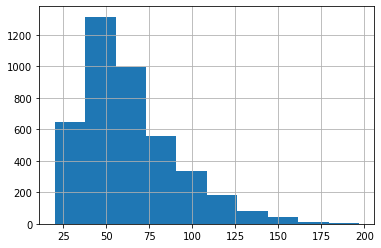

count    4187.000000
mean       63.792355
std        27.772365
min        20.000000
25%        43.000000
50%        57.400000
75%        78.000000
max       197.000000
Name: total_area, dtype: float64

In [26]:
#общая площадь
data['total_area'].hist(bins=10)
plt.show()
data['total_area'].describe()


Построив гистограмму общей площади квартир, можно сделать вывод, что распределение данных близко к нормальному. Наибольший процент значений приходится на 35-55 м^2. Медианное значение 51 м^2, а среднее 56 м^2. Разница между ними объяснима: распределение не является идеально нормальным, значениия выше медианного преобладают, но это не является ошибкой, потому что понятно, что не существует квартир меньше какого-то небольшого метража (в наших данных минимальное значение 20). Такие квартиры представляют собой либо студии, либо однокомнатные квартиры, а вариантов с метражом выше среднего гараздо больше. Потому что нет какого-то строгого ограничения сверху на количество квадратных метров квартиры ( конкретно в нашем датасете максимальное значение 1977, они могут представлять собой от студий, до 5, 6 и т.д. -квартирных помещений.

Данные действительно отображают реальную картину.

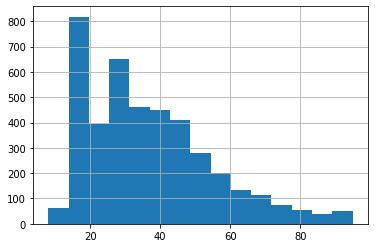

count    4187.000000
mean       36.708168
std        17.880303
min         8.000000
25%        20.550000
50%        33.000000
75%        47.000000
max        95.000000
Name: living_area, dtype: float64

In [27]:
#жилая площадь
data['living_area'].hist(bins=15)
plt.show()
data['living_area'].describe() 

Построив гистограмму, можно сделать вывод, что распределение данных близко к реальному. Наибольший процент значений приходится на 17-20 м^2. Медианное значение 30 м^2, а среднее 32 м^2. Разница между ними объяснима: по гистограмме видно, что количество значений меньше медианного явно меньше, чем тех, которые больше него. (опять же это можно объяснить теми же размышлениями про ограничения площади квартиры сверху и снизу)
Минимальное значение - 8 кв.м
Максимальное значение - 95 кв.м
Данные действительно отображают реальную картину.

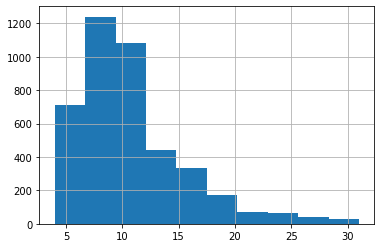

count    4187.000000
mean       10.790191
std         4.728228
min         4.000000
25%         7.400000
50%        10.000000
75%        13.000000
max        31.000000
Name: kitchen_area, dtype: float64

In [28]:
#площадь кухни
data['kitchen_area'].hist(bins=10)
plt.show()
data['kitchen_area'].describe()

Построив гистограмму, можно сделать вывод, что распределение данных близко к реальному. Наибольший процент значений приходится на 7-9 м^2. Медианное значение 9 м^2, а среднее 10 м^2. Разница между ними очень небольшая.
Минимальное значение - 4 кв.м
Максимальное значение - 31 кв.м

Данные действительно отображают реальную картину.

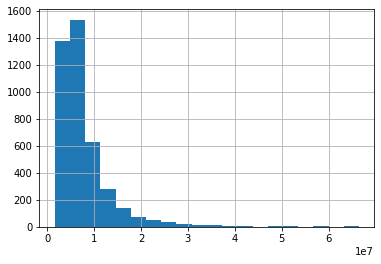

count    4.187000e+03
mean     7.838778e+06
std      6.190925e+06
min      1.600000e+06
25%      4.350000e+06
50%      6.000000e+06
75%      8.988706e+06
max      6.650000e+07
Name: last_price, dtype: float64

In [29]:
#цена объекта
data['last_price'].hist(bins=20)
plt.show()
data['last_price'].describe()

Построив гистограмму, можно сделать вывод, что распределение данных близко к реальному. Наибольший процент значений приходится на 4-7 млн рублей. Медианное значение 4.5 млн рублей, а среднее 5.31 млн рублей. Также много квартир дешевле промежутка 4-7 млн рублей, и меньше тех, что дороже. Больше 10 млн рублей продалось квартир значительно меньше. Минимальная стоимость квартиры составляет 430 тыс рублей, а максимальная  65 млн рублей. Такой разброс говорит о том, что стоимость значительно варьируется, а значит скорее всего сильно зависит от всевозможных параметров.


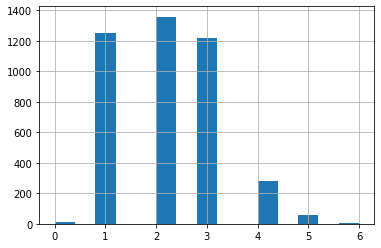

count    4187.000000
mean        2.171244
std         0.998113
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         6.000000
Name: rooms, dtype: float64

In [30]:
#количество комнат
data['rooms'].hist(bins=15)
plt.show()
data['rooms'].describe()

Построив гистограмму видно, что наиболее распространенные варианты квартир - это однокомнатные и двухкомнатные. Также продается достаточно много 3-комнатных квартир, а остальных - кратно меньше. Это логично, потому что 1 и 2 - комнатные квартиры более популярны, потому что сейчас в Санкт-Петербург стекается множество молодых людей, которым для начала вполне достаточно 1- комнатной квартиры, и также логично предположить, что 2 - комнатные квартиры пользуются спросом среди молодых семей. А это в совокупности очень большая часть целевой аудитории, готовой покупать недвижимость.

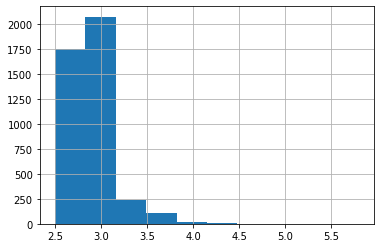

count    4187.000000
mean        2.879859
std         0.275836
min         2.500000
25%         2.650000
50%         3.000000
75%         3.000000
max         5.800000
Name: ceiling_height, dtype: float64

In [31]:
#высота потолков
data['ceiling_height'].hist(bins=10)
plt.show()
data['ceiling_height'].describe()

Построив гистограму видим, что средняя высота потолков и медианное значения равны 2,8 м. наибольший процент значений наблюдается в интервале от 2,5 до 3 м. Это звучит правдоподобно, потому что это стандартная высота потолков, также есть квартиры с более высокими потолками, тем более в этом городе специфика архитектуры подразумевает это.

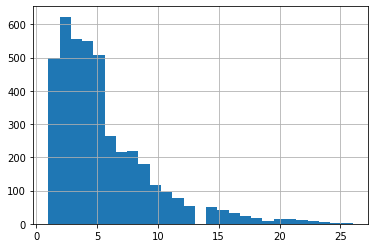

count    4187.000000
mean        5.348698
std         4.120582
min         1.000000
25%         2.000000
50%         4.000000
75%         7.000000
max        26.000000
Name: floor, dtype: float64

In [32]:
#этаж квартиры;
data['floor'].hist(bins=27)
plt.show()
data['floor'].describe()

По гистограмме видно, что график убывает, что вполне логично, так как первые этажы есть во всех домах, а 27 (max) имеют только высотки. Соответственно, чем выше этаж, тем реже он может встретиться.

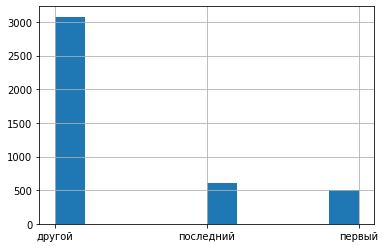

count       4187
unique         3
top       другой
freq        3079
Name: floor_, dtype: object

In [33]:
#тип этажа квартиры («первый», «последний», «другой»);
data['floor_'].hist(bins=10)
plt.show()
data['floor_'].describe()

Кратно чаще встречается тип этажа "другой". Это выглядит правдоподобно, так как первый и последний этажи - это всего лишь два варианта этажа, а другой - все варианты этажей между ними. К тому же, с точки зрения жизни, люди стараются, в основном, купить квартиру типа "другой", потому что на первом этаже окна находятся на уровне глаз прохожих, а на последнем этаже - выше вероятность протечки крыши.

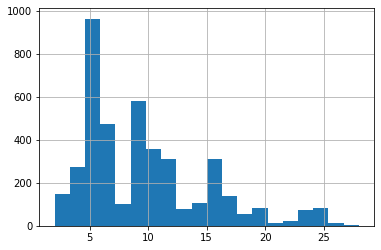

count    4187.000000
mean        9.567471
std         5.381208
min         2.000000
25%         5.000000
50%         9.000000
75%        12.000000
max        28.000000
Name: floors_total, dtype: float64

In [34]:
#общее количество этажей в доме;
data['floors_total'].hist(bins=20)
plt.show()
data['floors_total'].describe()

Самые часто встречающиеся дома в нашей выборке являются 4-5 или 8-9 этажными. Но также есть высокие дома до 29 этажей (max). Аналогично есть дома с меньшим количеством этажей.

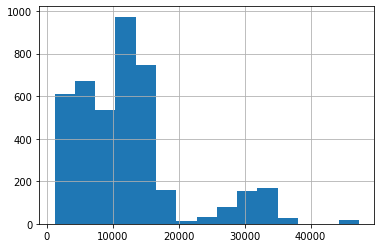

count     4187.000000
mean     12260.505374
std       8321.348568
min       1178.000000
25%       6072.000000
50%      11490.000000
75%      14895.500000
max      47318.000000
Name: cityCenters_nearest, dtype: float64

In [35]:
#расстояние до центра города в метрах
data['cityCenters_nearest'].hist(bins=15)
plt.show()
data['cityCenters_nearest'].describe()

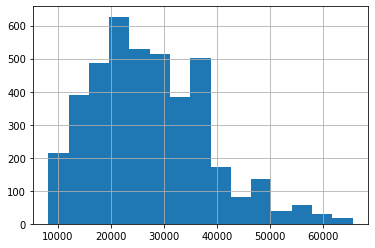

count     4187.000000
mean     27499.944590
std      10934.114849
min       8255.000000
25%      19523.500000
50%      26585.000000
75%      34843.000000
max      65568.000000
Name: airports_nearest, dtype: float64

In [36]:
#расстояние до ближайшего аэропорта
data['airports_nearest'].hist(bins=15)
plt.show()
data['airports_nearest'].describe()

Медианное значение расстояния до ближайшего аэропорта равно 27 км, что также похоже на правду. Минимальное - 7,9 км, а максимальное - 65 км.

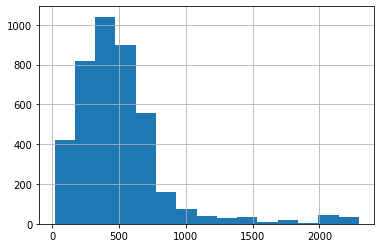

count    4187.000000
mean      502.120373
std       356.569495
min        17.000000
25%       288.000000
50%       444.000000
75%       618.000000
max      2295.000000
Name: parks_nearest, dtype: float64

In [37]:
#расстояние до ближайшего парка
data['parks_nearest'].hist(bins=15)
plt.show()
data['parks_nearest'].describe()


Расстояние до ближайшего парка в основном варьируется от 400 до 550 м. МЕдианное значение 455м, а среднее - 459 м. Однако есть квартиры с шаговой доступностью парка (37 м - минимальное значение), а есть, наоборот, на большом расстоянии от парков (максимальное значение - 1942 м)

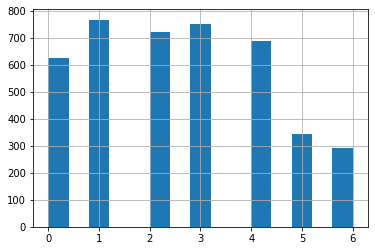

count    4187.000000
mean        2.551947
std         1.780438
min         0.000000
25%         1.000000
50%         2.000000
75%         4.000000
max         6.000000
Name: week_day, dtype: float64

In [38]:
#день публикации объявления
data['week_day'].hist(bins=15)
plt.show()
data['week_day'].describe()

Построив гистограмму видно, что в будние дни люди чаще выставляют объявления, чем в выходные           

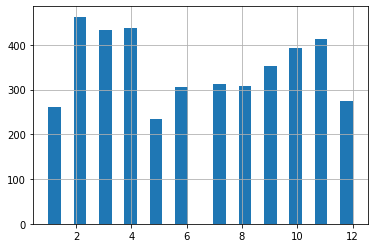

count    4187.000000
mean        6.405780
std         3.467189
min         1.000000
25%         3.000000
50%         6.000000
75%        10.000000
max        12.000000
Name: month, dtype: float64

In [39]:
#месяц публикации объявления
data['month'].hist(bins=24)
plt.show()
data['month'].describe()

Наибольшее количество объявлений приходится на февраль, а наименьшее - на май. Если смотреть более обще, то можно увидеть, что в середине года выставляется меньше объявлений, чем в начале и в конце (то есть летом менее активно).

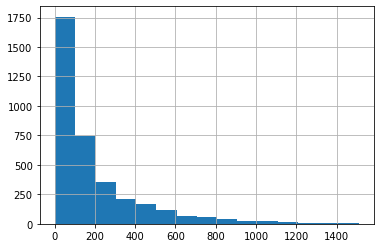

Медианное значение 105.0
Среднее значение 196.29413400055603
min значение 1.0
max значение 1512.0000000000002


In [40]:
#Изучим как быстро продавались квартиры
data['days_exposition'].hist(bins=15)
plt.show()
print('Медианное значение',data['days_exposition'].median())
print('Среднее значение',data['days_exposition'].mean())
print('min значение',data['days_exposition'].min())
print('max значение',data['days_exposition'].max())

График похож на распределение Пуассона. Медианное значение равно 95 дней, а среднее - 164 дня. Разница объяснима, так как по диаграмме видно, что наиболее часто встречающиеся значения, это значения <= медианному. После него разброс более обширный, но и более редкий. Быстрыми можно назвать продажи меньше чем за 95 дней, а медлиными - больше 200. Промежуток между ними будем считать нормальным сроком продажи квартиры.

Рассмотрим какие факторы больше всего влияют на общую стоимость объекта? Построим графики, которые покажут зависимость цены от различных параметров ( общей площади; жилой площади; площади кухни; количество комнат; типа этажа, на котором расположена квартира; даты размещения). Для подготовки данных перед визуализацией используем сводные таблицы.

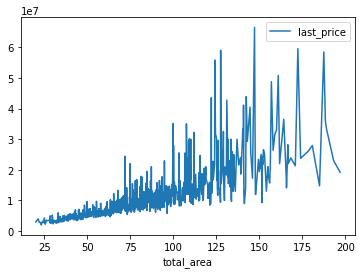

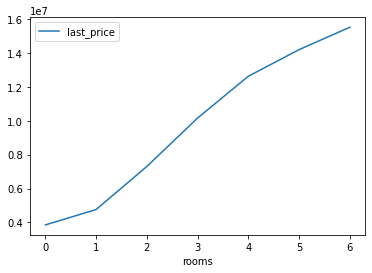

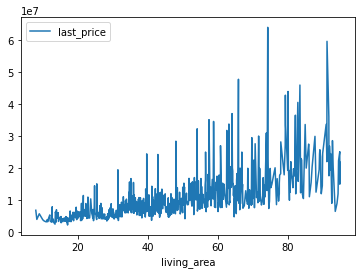

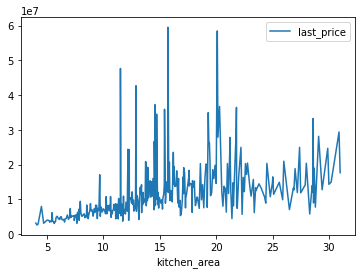

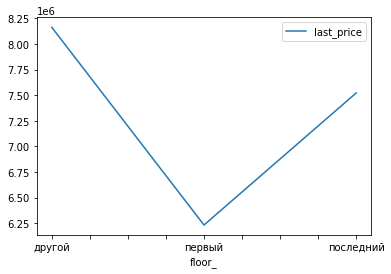

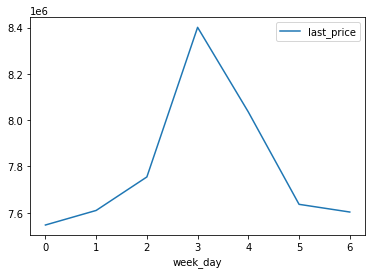

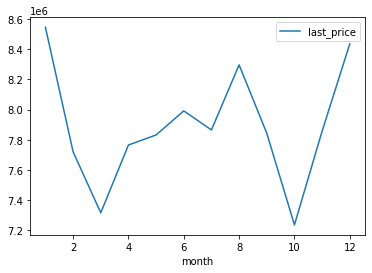

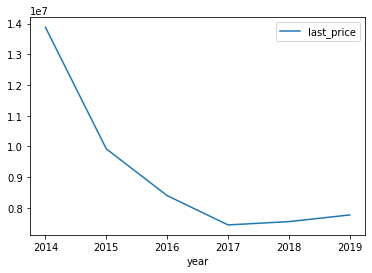

In [41]:
data_for_pivot_table = ['total_area', 'rooms', 'living_area', 'kitchen_area', 'floor_', 'week_day', 'month', 'year']

for i in data_for_pivot_table:
    data_pivot_table = data.pivot_table(index=[i], values=['last_price'])
    data_pivot_table.plot()

In [42]:
data_for_corr = ['total_area', 'rooms', 'living_area', 'kitchen_area']

for i in data_for_corr:
    print(f'корреляция для {i} =')
    print(data[i].corr(data['last_price']))

корреляция для total_area =
0.7312314324259724
корреляция для rooms =
0.41837604980122783
корреляция для living_area =
0.6381901064407877
корреляция для kitchen_area =
0.532784570912118


Наибольшее влияние на общую стоимость квартиры оказывают такие параметры, как общая площадь и жилая площадь. Зависимость прямая, то есть чем больше значение параметра, тем выше цена. Что вполне логично, так как в основном при покупки квартиры обращают внимание именно на эти факторы, потому что от них напрямую зависит сколько людей смогут разместиться в квартире. Также большое влияние имеет тип этажа. Первый этаж стоит обычно дешевле всех, последний - уже дороже, но все-таки его стоимость меньше любого другого промежуточного этажа. Это связано с тем, что  первый этаж находится на уровни глаз прохожих и это минус, а у последнего этажа есть вероятность протечки крыши или еще каких-то технических неполадок. К тому же по видно, что стоимость квартир с большим количеством комнат и большей площадью кухни в среднем выше. Естественно, стоимость квартиры также зависит от года, потому что этот параметр отражает экономическую и политическую ситуацию, а значит и цены на недвижимость. Помимо этого можно увидеть, что цены более высокие на квартиры, которые выставили в будние дни, но это не самый показательный фактор.

Найдем 10 населённых пунктов с наибольшим числом объявлений

In [43]:
data_group = data.groupby(by = ['locality_name']).count()
data_group_10 = data_group.sort_values(by=['last_price'], ascending=False).head(10)
locality_10 = data_group_10.index.values
locality_10

array(['санкт-петербург', 'пушкин', 'петергоф', 'сестрорецк', 'колпино',
       'павловск', 'кронштадт', 'поселок стрельна', 'поселок парголово',
       'красное село'], dtype=object)

In [44]:
max_price = 0
min_price = 1000000000
for i in locality_10:
    data_mean_last_price = data[ data['locality_name']== i]['last_price'].mean()
    data_mean_total_area = data[ data['locality_name']== i]['total_area'].mean()
    data_price_1m = data_mean_last_price / data_mean_total_area
    if data_price_1m >= max_price:
        max_price = data_price_1m
        max_price_location = i
    if data_price_1m <= min_price:
        min_price = data_price_1m
        min_price_location = i
        
    print(f'Средняя цена за квадратный метр в {i} равна {data_price_1m} рублей')

Средняя цена за квадратный метр в санкт-петербург равна 125631.27023943308 рублей
Средняя цена за квадратный метр в пушкин равна 108570.00296550387 рублей
Средняя цена за квадратный метр в петергоф равна 87840.48257874273 рублей
Средняя цена за квадратный метр в сестрорецк равна 112493.02930725043 рублей
Средняя цена за квадратный метр в колпино равна 75265.30695586326 рублей
Средняя цена за квадратный метр в павловск равна 92266.48031679477 рублей
Средняя цена за квадратный метр в кронштадт равна 78695.40555870676 рублей
Средняя цена за квадратный метр в поселок стрельна равна 87032.29932842981 рублей
Средняя цена за квадратный метр в поселок парголово равна 78704.20269099525 рублей
Средняя цена за квадратный метр в красное село равна 75769.76279522516 рублей


In [45]:
print(f'Из списка этих населенных пунктов самая дорогая недвижимость в {max_price_location}')
print(f'Из списка этих населенных пунктов самая дешевая недвижимость в {min_price_location}')

Из списка этих населенных пунктов самая дорогая недвижимость в санкт-петербург
Из списка этих населенных пунктов самая дешевая недвижимость в колпино


Выделим квартиры в Санкт-Петербурге и вычислим среднюю цену каждого километра до центра.

In [46]:
data_spb = data[ data['locality_name'] == 'санкт-петербург']

data_mean_last_price = data_spb['last_price'].mean()
data_mean_cityCenters_nearest = data_spb['cityCenters_nearest_km'].mean()
data_price_1m_cityCenters = data_mean_last_price / data_mean_cityCenters_nearest
print(f'Цена к{data_price_1m_cityCenters}')

Цена к819615.6282323815


<AxesSubplot:xlabel='cityCenters_nearest_km'>

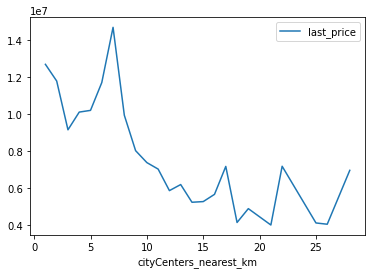

In [47]:
#Диаграмма, показывающая зависимость стоимости квартиры от расстояния до центра
cityCenters_neares_pivot_table = data_spb.pivot_table(index=['cityCenters_nearest_km'], values=['last_price'])
cityCenters_neares_pivot_table.plot()

По графику видно, что зависимость цены квартиры от ее дальности от центра не прямая (т.к. на цену влияют много других факторов, о которых было сказано выше), но она существует. Чем ближе квартира к центру, тем она дороже.

### Общий вывод

В моем распоряжении были данные сервиса Яндекс Недвижимости — архива объявлений за несколько лет о продаже квартир в Санкт-Петербурге и соседних населённых пунктах. Мне нужно было найти интересные особенности и зависимости, которые существуют на рынке недвижимости. Я могу сделать следующий вывод: финальная стоимость квартиры складывается из совокупности факторов, некоторые из которых играют более существенную роль, другие - менее. Цена надвижимости зависит в большей степени от:


1. Общей площади. 

Самая распространенная характеристика стоимости недвижимости - это цена за квадратный метр.ЧЕм больше квартира, тем она дороже.

2. Количества комнт. 

Чем больше комнат, тем дороже квартира. Это вполне логично, так как этот параметр связан и с общей площадью.

3. Типа этажа.
Квартиры на первых и последних этажах стоят дешевле. Это объясняется тем, что перрвый этаж находится на уровне глаз прохожих и в старых постройках есть вероятность, что в квартире будет чуствоваться запах котельной/подвала. А на последних этажах выше шанс технических неполадок дома, например, протечки крыши.
4. Отдаленности от центра города.
Целевая аудитория для покупки недвижимости - это работающие люди, для них актуально жить ближе к центру, чтобы было легче добираться до места работы, даже если они решат его сменить. Опять же в центре лучше инфраструктура, доступность школ, детских садов, магазинов, аптек и т.д. Поэтому расстояние до центра - это важный фактор стоимости квартииры. Однако некоторые люди хотят купить себе жилье, наоборот, за городом, напримен, в качестве дачи.
5. Площади кухни и жилой площадию.
Исследование показало, что стоимость квартиры выше, если эти параметры больше. Этот факт также объясним, так как эти показатели также связаны с общей площадью. К тому же кухня - это место, где люди принимают гостей и его более большая площадь приветствуется.
6. Года выставления объявления.
Как я уже писала ранее, год определяет общую ситуацию на рынке недвижимости, которая складывается из политической, экономической и других сфер, которые определяют спрос на недвижимость, стоимость ремонта и так далее.
7. Расстояния до ближайшего парка/водоема.
Большая часть покупателей - это семьи и пары, планирующие завести ребенка, соответственно для них важно наличие места, где можно погулять в шаговой доступности. В целом, большинство людей считают плюсом иметь рядом с домом место для прогулки, поэтому этот параметр отражается на стоимости недвижимости.


Для будущих исследований я  бы добавила такие параметры, как год постройки дома и степень готовности недвижимости (черновая отделка, под ключ, с мебелью и т.д.). Я думаю, что они бы помогли собрать данные для более полного анализа.